# 01_summary_statistics.ipynb

In [19]:
import contextily as cx
import figure_utilities
import figure_and_table_constants
from analysis_utilities import produce_summary_statistics
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd
from scipy import stats
import xyzservices.providers as xyz

# Store paths.
INPUT_DATA_UNRESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/unrestricted.csv"
INPUT_DATA_RESTRICTED = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/tables"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/summary_statistics/figures"

# Read unrestricted dataset into memory.
unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)

# Drop malformed addresses.
unrestricted_df = unrestricted_df.loc[~unrestricted_df['property_address_full'].str.contains("span, span span"), :]

/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_73286/795176550.py:26: DtypeWarning: Columns (149,151) have mixed types. Specify dtype option on import or set low_memory=False.
  unrestricted_df = pd.read_csv(INPUT_DATA_UNRESTRICTED)


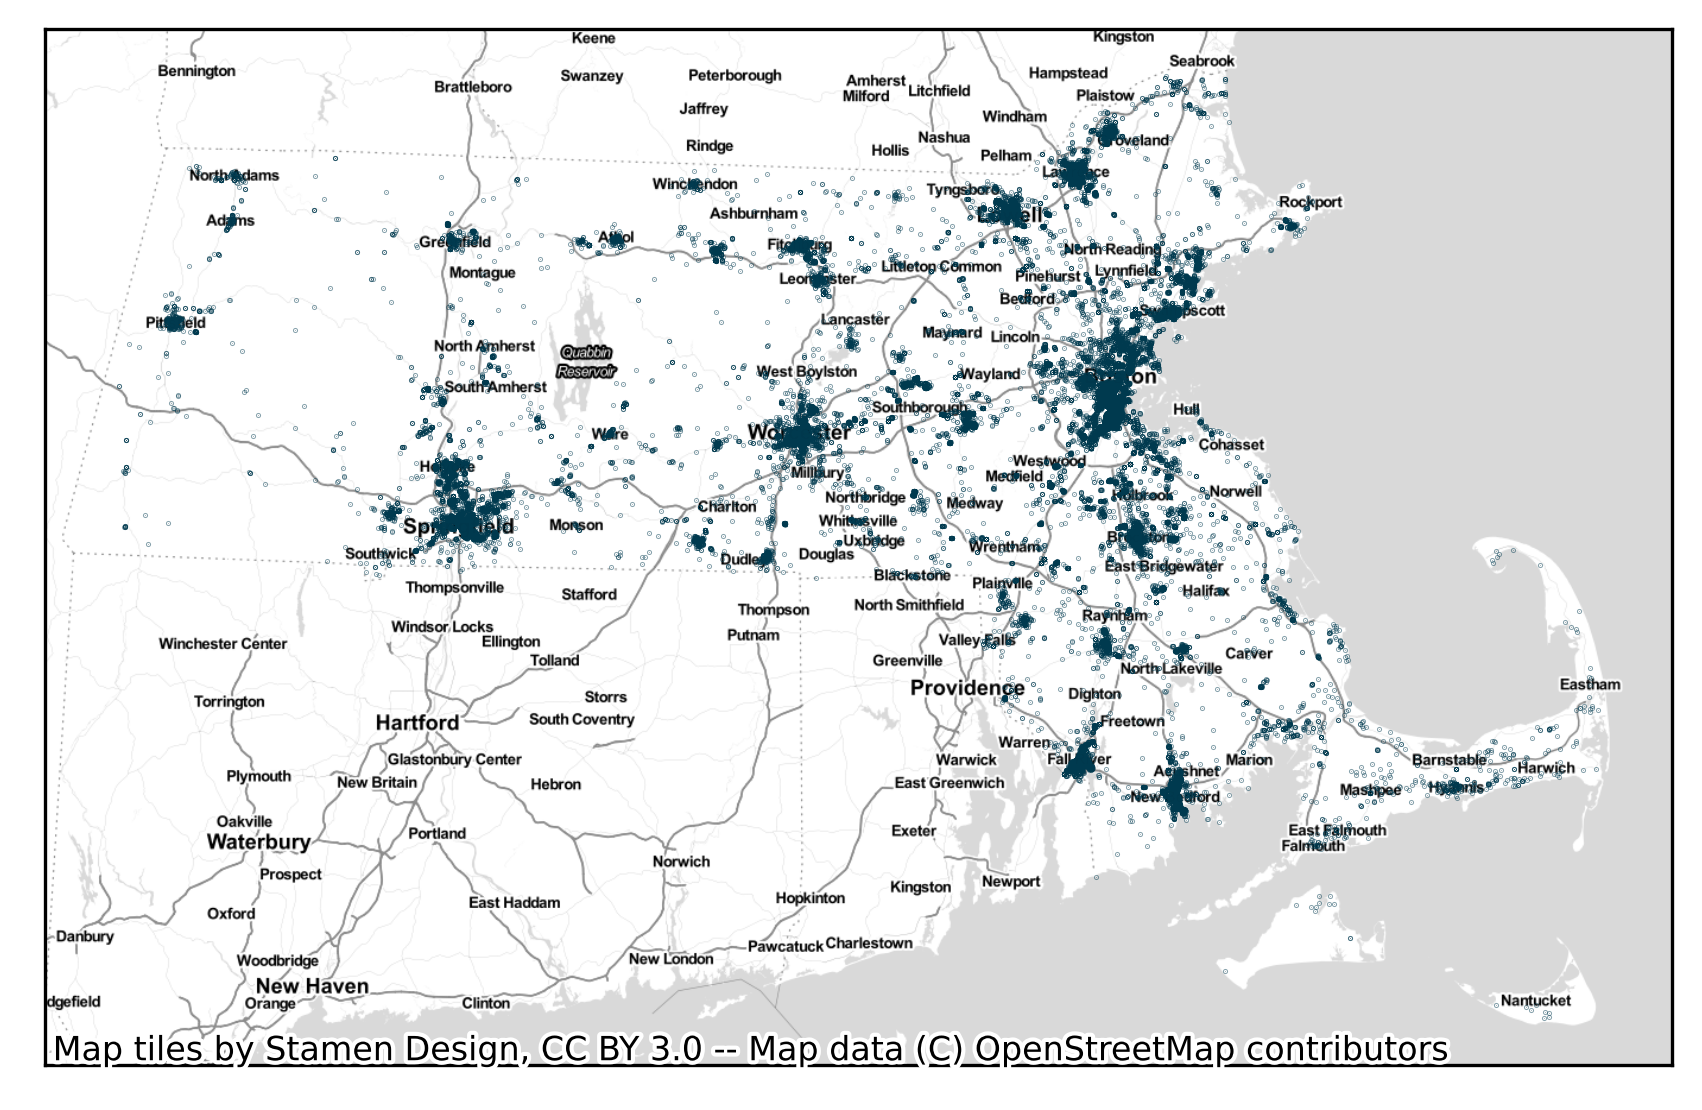

In [20]:
# Plot evictions spatially.
unrestricted_gdf = gpd.GeoDataFrame(unrestricted_df,
                                    geometry=gpd.points_from_xy(unrestricted_df['longitude'],
                                                                unrestricted_df['latitude']))
unrestricted_gdf = unrestricted_gdf.set_crs("EPSG:4326")
unrestricted_gdf = unrestricted_gdf.to_crs("EPSG:3857")
fig, ax = plt.subplots(figsize=(7, 9))
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_xticks([])
unrestricted_gdf.plot(ax=ax,
                      color=figure_and_table_constants.Colors.P3,
                      markersize=0.05,
                      alpha=0.5)
cx.add_basemap(ax=ax, crs="EPSG:3857", source=cx.providers.Stamen.TonerLite)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "evictions_map.png"))

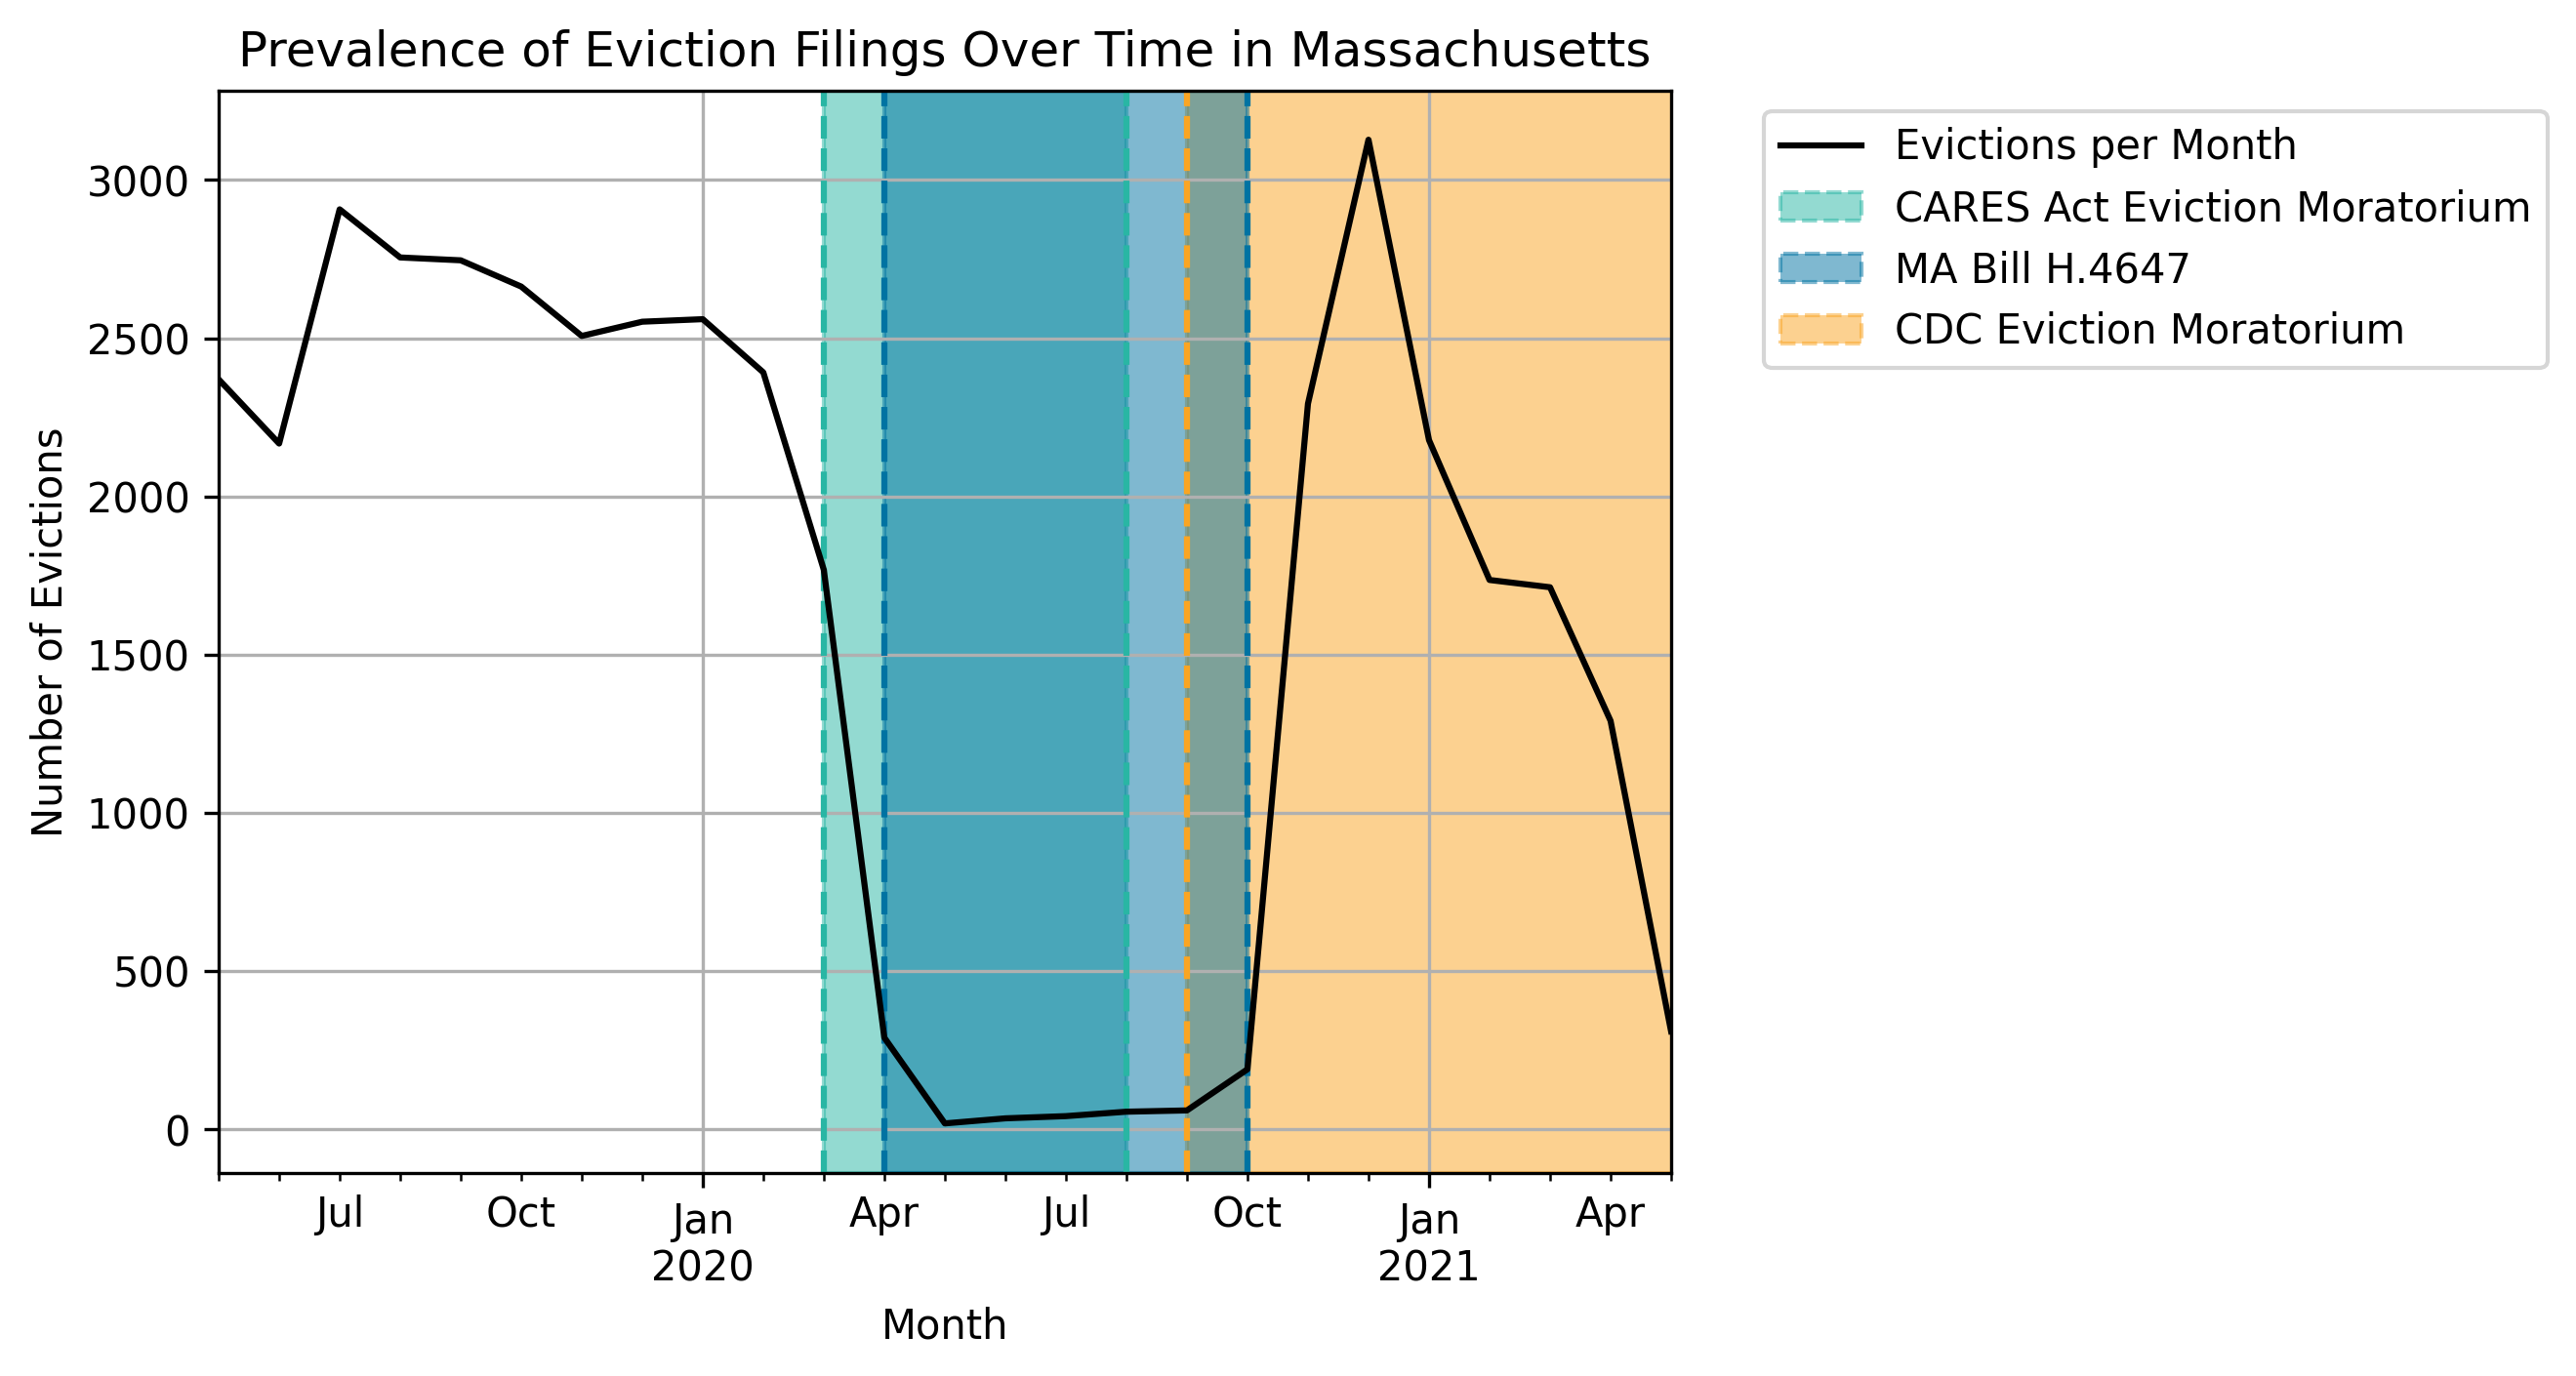

In [21]:
# Plot the number of eviction filings over time.
unrestricted_df.loc[:, 'last_day_of_file_month'] = (pd.to_datetime(unrestricted_df['file_date']) +
                                                    pd.tseries.offsets.MonthEnd(0))
filings_per_month = unrestricted_df.groupby('last_day_of_file_month')['case_number'].count()

# Plot eviction filing counts.
fig, ax = plt.subplots()
filings_per_month.plot(ax=ax, kind='line', color=figure_and_table_constants.Colors.SUMMARY_STATISTICS_COLOR,
                       zorder=100)
ax.set_title("Prevalence of Eviction Filings Over Time in Massachusetts")
ax.set_ylabel("Number of Evictions")
ax.set_xlabel("Month")
ax.grid(True)

# Plot the beginning and end of the CARES act moratorium.
CARES_beginning = pd.Timestamp("2020-03-27")
CARES_end = pd.Timestamp("2020-08-23")
CARES_color = figure_and_table_constants.Colors.P1
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_beginning, text='', color=CARES_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CARES_end, text='', color=CARES_color)
ax.axvspan(CARES_beginning, CARES_end, color=CARES_color, alpha=0.5)

# Plot the beginning and end of the CDC moratorium.
CDC_beginning = pd.Timestamp("2020-09-04")
CDC_end = pd.Timestamp("2021-08-26")
CDC_color = figure_and_table_constants.Colors.P2
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_beginning, text='', color=CDC_color)
figure_utilities.plot_labeled_vline(ax=ax, x=CDC_end, text='', color=CDC_color)
ax.axvspan(CDC_beginning, CDC_end, color=CDC_color, alpha=0.5)

# Plot the beginning and end of the MA state moratorium.
MA_beginning = pd.Timestamp("2020-04-20")
MA_end = pd.Timestamp("2020-10-17")
MA_color = figure_and_table_constants.Colors.P7
figure_utilities.plot_labeled_vline(ax=ax, x=MA_beginning, text='', color=MA_color)
figure_utilities.plot_labeled_vline(ax=ax, x=MA_end, text='', color=MA_color)
ax.axvspan(MA_beginning, MA_end, color=MA_color, alpha=0.5)

# Build legend.
legend_elements = [Line2D([0], [0], color='black', label='Evictions per Month'),
                   Patch(facecolor=CARES_color, edgecolor=CARES_color, label='CARES Act Eviction Moratorium',
                         alpha=0.5, linestyle='--'),
                   Patch(facecolor=MA_color, edgecolor=MA_color, label='MA Bill H.4647', alpha=0.5,
                         linestyle='--'),
                   Patch(facecolor=CDC_color, edgecolor=CDC_color, label='CDC Eviction Moratorium', alpha=0.5,
                         linestyle='--')]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "filings_over_time.png"))

In [22]:
# Produce summary statistics for unrestricted sample.
treatment_date_variable = 'file_date'
summary_statistics_unrestricted = produce_summary_statistics(unrestricted_df, treatment_date_variable=treatment_date_variable)

# Rename rows.
variable_names = summary_statistics_unrestricted.index.get_level_values(1)
variable_display_names_dict = {'for_cause': "For cause", 'no_cause': "No cause", 'non_payment': "Non-payment of rent",  # Panel A
                               'case_duration': "Case duration", 'defaulted': "Case defaulted", 'heard': "Case heard",  # Panel B
                               'judgment': "Money judgment", 'mediated': "Case mediated", 'dismissed': 'Case dismised', # Panel B
                               'hasAttyD': "Defendant has an attorney", 'hasAttyP': "Plaintiff has an attorney",  # Panel C
                               'isEntityD': "Defendant is an entity", 'isEntityP': "Plaintiff is an entity",  # Panel C
                               'TOTAL_VAL': "Total property value", 'BLDG_VAL': "Building value", 'LAND_VAL': "Land value",  # Panel D
                               'OTHER_VAL': "Other value",  # Panel D
                               'med_hhinc2016': 'Median household income (2016)', 'popdensity2010': 'Population density (2010)',  # Panel E
                                'share_white2010': 'Portion white (2010)',  # Panel E
                               'zestimate_-5_years_relative_to_treatment': "Five years before filing date",
                               'zestimate_-4_years_relative_to_treatment': "Four years before filing date",
                               'zestimate_-3_years_relative_to_treatment': "Three years before filing date",
                               'zestimate_-2_years_relative_to_treatment': "Two years before filing date",
                               'zestimate_-1_years_relative_to_treatment': "One year before filing date",
                               'zestimate_0_years_relative_to_treatment': "Filing date",
                               'zestimate_1_years_relative_to_treatment': "One year after filing date",
                               'zestimate_2_years_relative_to_treatment': "Two years after filing date",
                               'zestimate_3_years_relative_to_treatment': "Three years after filing date"}

summary_statistics_unrestricted = summary_statistics_unrestricted.rename(index=variable_display_names_dict)

# Rename columns.
summary_statistics_unrestricted.index = summary_statistics_unrestricted.index.set_names(["Panel", "Variable"])
column_display_names_dict = {'mean': "Mean", 'std': "S.D.", 'count': "N", '50%': 'Median'}
summary_statistics_unrestricted = summary_statistics_unrestricted.rename(columns=column_display_names_dict)
summary_statistics_unrestricted = summary_statistics_unrestricted.sort_values(['Panel', 'Variable'])

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "summary_statistics.tex")
latex = (summary_statistics_unrestricted
         .style
         .format(formatter={
                            'Mean': "{:,.2f}",
                            'Median': "{:,.2f}",
                            'S.D.': "{:,.2f}",
                            'N': "{:,.0f}"})
         .format_index("\\textit{{{}}}", escape="latex", axis=0, level=0)
         .to_latex(None,
                   column_format="llcccc",
                   hrules=True,
                   clines="skip-last;data")).replace("{*}", "{3cm}")
with open(filename, 'w') as file:
    file.write(latex)
summary_statistics_unrestricted

Mean  \
Panel                                            Variable                                       
Panel A: Case Initiation                         For cause                       1.221548e-01   
                                                 No cause                        1.074471e-01   
                                                 Non-payment of rent             7.492572e-01   
Panel B: Case Resolution                         Case defaulted                  1.955951e-01   
                                                 Case dismised                   2.861983e-01   
                                                 Case duration                   5.781477e+01   
                                                 Case heard                      5.743119e-02   
                                                 Case mediated                   4.144916e-01   
                                                 Money judgment                  1.890340e+03   
Panel C: Defendant and Plaintiff Characteristics Defendant has an attorney       8.642915e-02   
                                                 Defendant is an entity          6.261203e-03   
                                                 Plaintiff has an attorney       8.399833e-01   
                                                 Plaintiff is an entity          7.033418e-01   
Panel D: Assessor Records                        Building value                  8.350204e+06   
                                                 Land value                      2.471066e+06   
                                                 Other value                     1.125758e+05   
                                                 Total property value            1.090068e+07   
Panel E: Census Tract Characteristics            Median household income (2016)  5.265944e+04   
                                                 Population density (2010)       9.159771e+03   
                                                 Portion white (2010)            5.829843e-01   
Panel F: Zestimates Around Filing Date           Filing date                     3.773840e+05   
                                                 Five years before filing date   2.614629e+05   
                                                 Four years before filing date   2.802433e+05   
                                                 One year after filing date      4.216018e+05   
                                                 One year before filing date     3.511721e+05   
                                                 Three years after filing date   5.016118e+05   
                                                 Three years before filing date  3.071372e+05   
                                                 Two years after filing date     4.779481e+05   
                                                 Two years before filing date    3.410841e+05   

                                                                                        Median  \
Panel                                            Variable                                        
Panel A: Case Initiation                         For cause                            0.000000   
                                                 No cause                             0.000000   
                                                 Non-payment of rent                  1.000000   
Panel B: Case Resolution                         Case defaulted                       0.000000   
                                                 Case dismised                        0.000000   
                                                 Case duration                       21.000000   
                                                 Case heard                           0.000000   
                                                 Case mediated                        0.000000   
                                                 Money judgment                       0.000000   
Pan

In [23]:
# Load restricted data.
restricted_df = pd.read_csv(INPUT_DATA_RESTRICTED)
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_year_variable = treatment_date_variable.replace("date", "year")
treatment_month_variable = treatment_date_variable.replace("date", "month")
restricted_df = restricted_df.dropna(subset=['file_date', 'latest_docket_date'])
print(f"Limiting sample to {len(restricted_df)} evictions for which we observe the filing date and the latest docket date.")


# Create dictionaries to map between string representation and integer representation of each month.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}


Limiting sample to 2964 evictions for which we observe the filing date and the latest docket date.


In [24]:
treatment_timings = (restricted_df
                     .groupby([treatment_month_variable, 'judgment_for_plaintiff'])['case_number']
                     .count()
                     .reset_index()
                     .fillna(0))
treatment_timings = treatment_timings.pivot(index=treatment_month_variable, columns='judgment_for_plaintiff').fillna(0)
treatment_timings.columns = ["Cases Won By Defendant", "Cases Won By Plaintiff"]
portion_of_all_cases = (treatment_timings['Cases Won By Plaintiff'] + treatment_timings['Cases Won By Defendant']) / len(restricted_df)
treatment_timings = pd.concat([treatment_timings, portion_of_all_cases.rename('Portion of All Cases')], axis=1)
sum_across_filing_date = pd.DataFrame(treatment_timings.sum(axis=0)).T
sum_across_filing_date.index = ["All Filing Months"]
treatment_timings = pd.concat([sum_across_filing_date, treatment_timings], axis=0)
treatment_timings.index = treatment_timings.index.rename("Filing Month")

# Export to LaTeX.
filename = os.path.join(OUTPUT_TABLES, "treatment_timings.tex")
treatment_timings.style.format(formatter={'Cases Won By Plaintiff': '{:,.0f}',
                                          'Cases Won By Defendant': '{:,.0f}',
                                          'Portion of All Cases': '{:0.2f}'}).to_latex(filename, column_format="lccc", hrules=True)
treatment_timings

,Cases Won By Defendant,Cases Won By Plaintiff,Portion of All Cases
Filing Month,,,
All Filing Months,761.0,2203.0,1.000000
2019-05,3.0,12.0,0.005061
2019-06,38.0,146.0,0.062078
2019-07,42.0,195.0,0.079960
2019-08,31.0,176.0,0.069838
2019-09,37.0,152.0,0.063765
2019-10,33.0,144.0,0.059717
2019-11,23.0,129.0,0.051282
2019-12,28.0,164.0,0.064777


In [25]:
# Reshape from wide to long.
restricted_df = pd.melt(restricted_df,
                        id_vars=['case_number', treatment_month_variable, 'judgment_for_plaintiff'],
                        value_vars=value_vars, var_name='month', value_name='zestimate')
restricted_df = restricted_df.sort_values(by=['case_number', 'month'])

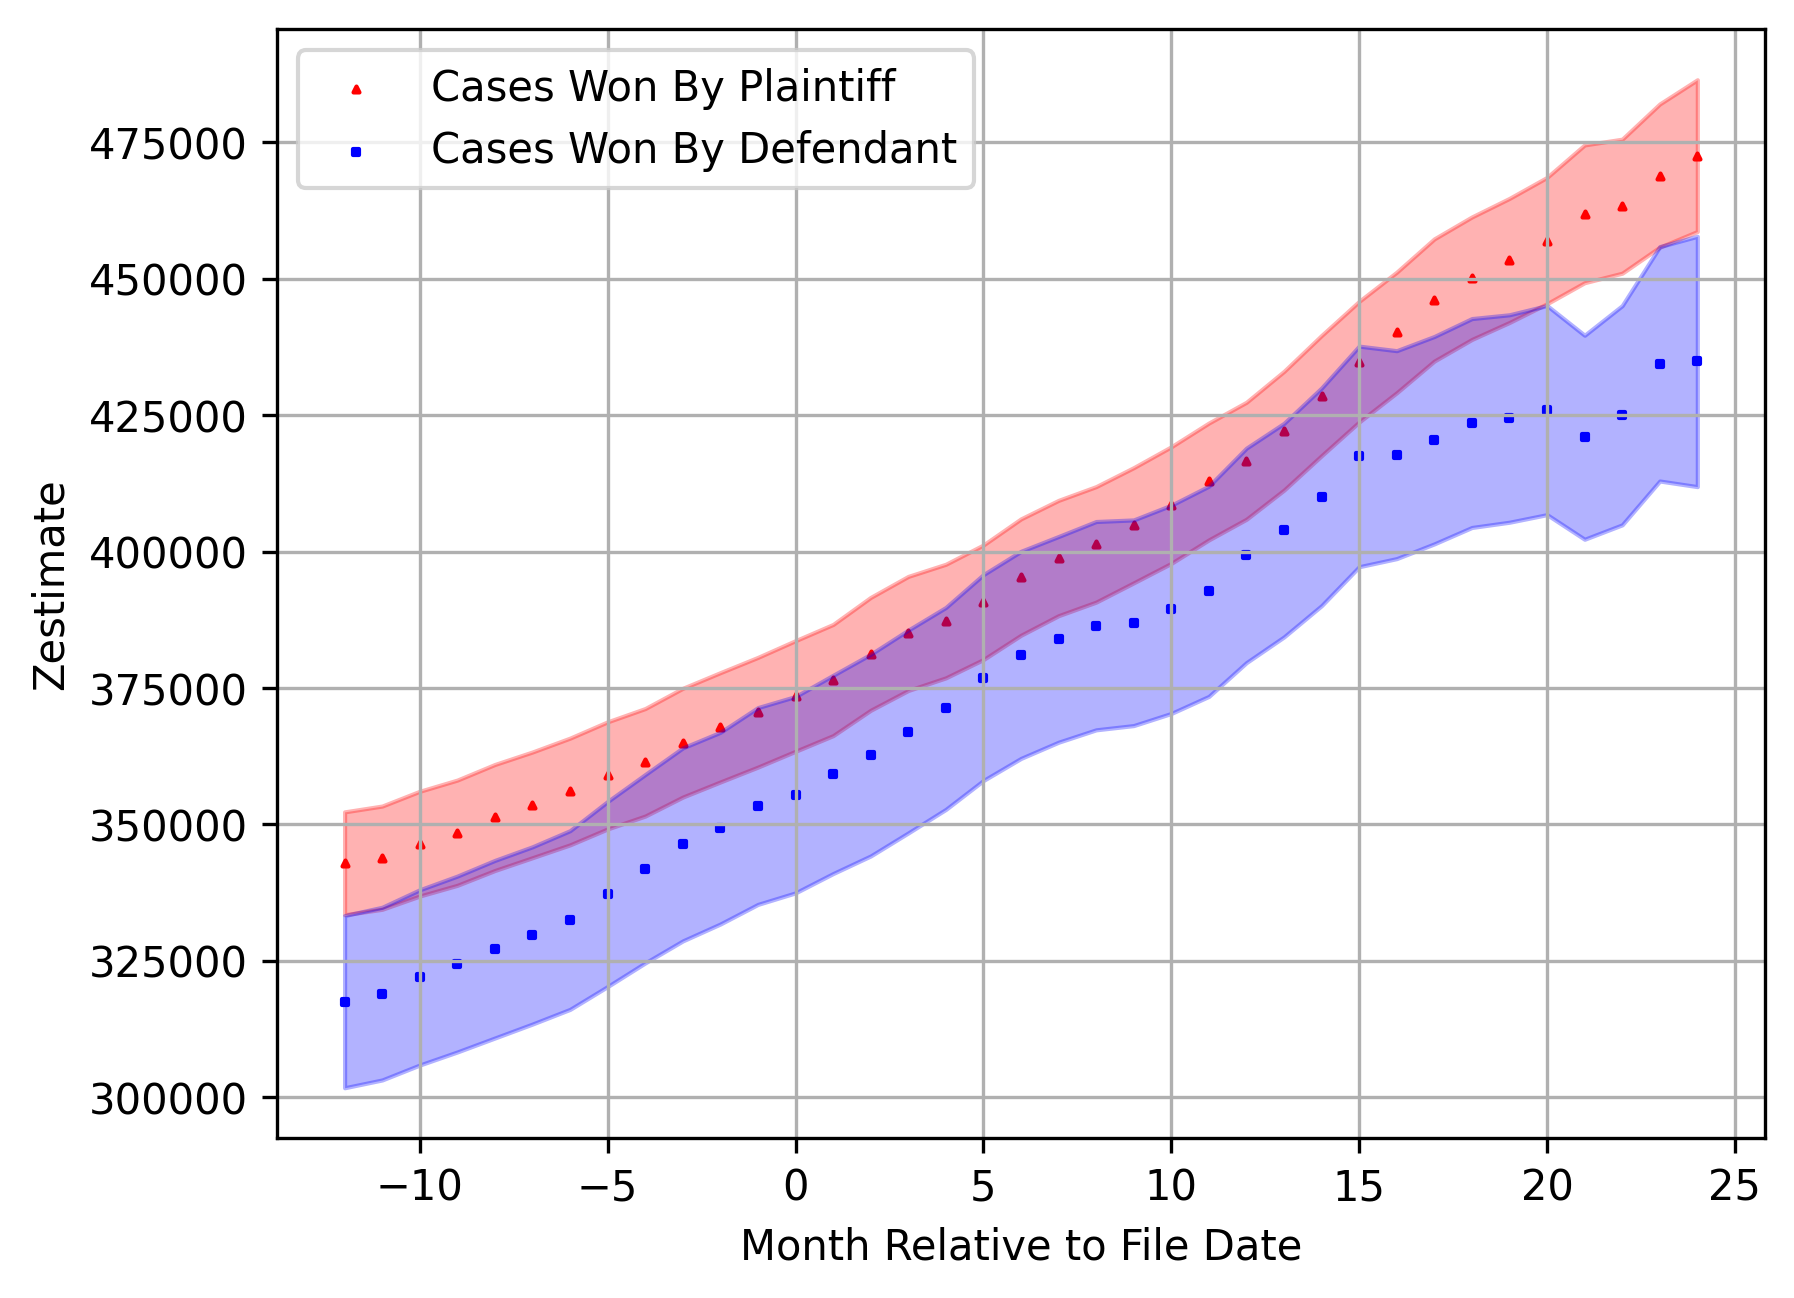

In [26]:
# Plot path of the outcome in the treated vs. control group.

# Convert months from string format to integer format.
restricted_df.loc[:, 'month'] = restricted_df['month'].replace(month_to_int_dictionary)
restricted_df.loc[:, treatment_month_variable] = restricted_df[treatment_month_variable].replace(month_to_int_dictionary)

# Generate month relative to treatment.
restricted_df.loc[:, 'month_relative_to_treatment'] = ((restricted_df['month'] - restricted_df[treatment_month_variable])
                                                       .astype(int))



# Aggregate by treatment-relative month and treatment status.
start_month_relative_to_treatment = -12
end_month_relative_to_treatment = 24
restricted_df = (restricted_df.groupby(['month_relative_to_treatment', 'judgment_for_plaintiff'])['zestimate']
                 .agg([np.mean, np.std, 'count'])
                 )
restricted_df.loc[:, 'se'] = restricted_df['std'] / np.sqrt(restricted_df['count'])
restricted_df.loc[:, 'y_upper'] = restricted_df['mean'] + 1.96 * restricted_df['se']
restricted_df.loc[:, 'y_lower'] = restricted_df['mean'] - 1.96 * restricted_df['se']

# Separate into control and treatment group
treated_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 1), :].reset_index()
control_units = restricted_df.loc[(slice(start_month_relative_to_treatment, end_month_relative_to_treatment), 0), :].reset_index()

# Plot event study-style plot of trends in Zestimates.
fig, ax = plt.subplots()
if treatment_date_variable == 'file_date':
    ax.set_xlabel("Month Relative to File Date")
elif treatment_date_variable == 'latest_docket_date':
    ax.set_xlabel("Month Relative to Latest Docket Date")
else:
    raise ValueError("Invalid treatment_date_variable.")
ax.set_ylabel("Zestimate")
for dataset, color, marker, label in zip([treated_units, control_units],
                                         ['red', 'blue'],
                                         ["^", "s"],
                                         ["Cases Won By Plaintiff",
                                          "Cases Won By Defendant"]):
    x = dataset['month_relative_to_treatment'].values
    y = dataset['mean'].values
    y_upper = dataset['y_upper'].values
    y_lower = dataset['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax=ax,
                                                     x=x,
                                                     y=y,
                                                     y_upper=y_upper,
                                                     y_lower=y_lower,
                                                     label=label,
                                                     point_color=color,
                                                     marker=marker,
                                                     error_color=color,
                                                     error_opacity=0.3)

ax.legend()
ax.grid(True)
plt.show()
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "trends_in_zestimates.png"))


